In [229]:
import pandas as pd
import numpy as np
import yfinance as yf 
import matplotlib.pyplot as plt
import talib as ta
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (20, 10)
import seaborn as sns



In [189]:
tickers=pd.read_csv('ind_nifty500list.csv')

In [190]:
tickers

,Company Name,Industry,Symbol,Series,ISIN Code
0,Amara Raja Batteries Ltd.,Automobile and Auto Components,AMARAJABAT.NS,EQ,INE885A01032
1,Apollo Tyres Ltd.,Automobile and Auto Components,APOLLOTYRE.NS,EQ,INE438A01022
2,Asahi India Glass Ltd.,Automobile and Auto Components,ASAHIINDIA.NS,EQ,INE439A01020
3,Bajaj Auto Ltd.,Automobile and Auto Components,BAJAJ-AUTO.NS,EQ,INE917I01010
4,Balkrishna Industries Ltd.,Automobile and Auto Components,BALKRISIND.NS,EQ,INE787D01026
...,...,...,...,...,...
513,GMR Airports Infrastructure Ltd.,Services,GMRINFRA.NS,EQ,INE776C01039
514,Motherson Sumi Wiring India Ltd.,Automobile and Auto Components,MSUMI.NS,EQ,INE0FS801015
515,Patanjali Foods Ltd.,Fast Moving Consumer Goods,PATANJALI.NS,BE,INE619A01035
516,Tata Teleservices (Maharashtra) Ltd.,Telecommunication,TTML.NS,BE,INE517B01013


## Master Dataframes


In [191]:
Masterdf=yf.download(tickers=tickers['Symbol'].to_list(),start='2012-1-1')['Close']

[*********************100%***********************]  515 of 515 completed


# Dealing with survivorship bias

We remove the top 50 stocks by returns. As we do not have the exact nifty 500 indices for every 6 months. Hence helpling us deal a little with the survivorship bias.

In [192]:
returns = (Masterdf.iloc[-1] - Masterdf.iloc[0]) / Masterdf.iloc[0]

# Step 2: Sort the returns in descending order
sorted_returns = returns.sort_values(ascending=False)

# Step 3: Get the top 50 stocks based on returns
top_50_stocks = sorted_returns.head(50)

# Step 4: Get the list of top 50 stock names
top_50_stock_names = top_50_stocks.index.tolist()

# Print the list of top 50 stock names
print(top_50_stock_names)


['ALKYLAMINE.NS', 'KEI.NS', 'JBMA.NS', 'ASTRAL.NS', 'DEEPAKNTR.NS', 'TANLA.NS', 'ICIL.NS', 'UNOMINDA.NS', 'TATAELXSI.NS', 'NAVINFLUOR.NS', 'APLAPOLLO.NS', 'OLECTRA.NS', 'RELAXO.NS', 'BHARATRAS.NS', 'KPRMILL.NS', 'GARFIBRES.NS', 'BALAMINES.NS', 'SONATSOFTW.NS', 'ADANIENT.NS', 'VINATIORGA.NS', 'SAREGAMA.NS', 'CCL.NS', 'VAIBHAVGBL.NS', 'SRF.NS', 'ATUL.NS', 'AJANTPHARM.NS', 'AARTIDRUGS.NS', 'CHOLAFIN.NS', 'GRANULES.NS', 'CERA.NS', 'AVANTIFEED.NS', 'CGCL.NS', 'CANFINHOME.NS', 'RATNAMANI.NS', 'WELSPUNIND.NS', 'POLYMED.NS', 'PIIND.NS', 'AEGISCHEM.NS', 'JBCHEPHARM.NS', 'BALKRISIND.NS', 'PERSISTENT.NS', 'ESCORTS.NS', 'CEATLTD.NS', 'KRBL.NS', 'FINCABLES.NS', 'TVSMOTOR.NS', 'GAEL.NS', 'TCI.NS', 'KNRCON.NS', 'SOLARINDS.NS']


In [193]:
new_list = [x for x in tickers['Symbol'].to_list() if x not in top_50_stock_names]


In [194]:
len(tickers['Symbol'].to_list()),len(new_list)

(518, 468)

In [195]:
Masterdf=yf.download(tickers=new_list,start='2012-1-1')

[*********************100%***********************]  465 of 465 completed


In [196]:
Mdf_Market=yf.download(tickers='^NSEI',start='2012-1-1')[['Open','Close']]


[*********************100%***********************]  1 of 1 completed


In [197]:
Mdf_Open=Masterdf['Open']
Mdf_High=Masterdf['High']
Mdf_Low=Masterdf['Low']
Mdf_Close=Masterdf['Close']

In [198]:
Mdf_Market['200ema']=ta.EMA(Mdf_Market['Close'],timeperiod=200)

In [199]:
Mdf_Market=Mdf_Market.dropna()

In [200]:
Mdf_ema=Mdf_Close.rolling(100).mean()

## Functions

In [201]:
def calculate_slope_r_squared(y):
    x = range(len(y))
    x = [[i] for i in x]
    model = LinearRegression().fit(x, y)
    slope = model.coef_[0]
    r_squared = model.score(x, y)
    return slope*r_squared

In [202]:
def calculate_atr(high, low, close, timeperiod):
    tr = pd.DataFrame(index=high.index)

    # True Range Calculation
    tr['tr1'] = high - low
    tr['tr2'] = np.abs(high - close.shift())
    tr['tr3'] = np.abs(low - close.shift())
    tr['true_range'] = tr[['tr1', 'tr2', 'tr3']].max(axis=1)

    # Average True Range Calculation
    atr = tr['true_range'].rolling(timeperiod).mean()

    return atr

In [203]:
def find_gap_stocks(Mdf_Open, Mdf_Close, threshold_percentage):
    gap_stocks = []
    
    for column in Mdf_Open.columns:
        open_prices = Mdf_Open[column]
        close_prices = Mdf_Close[column]
        
        gap_percentage = ((open_prices - close_prices.shift()) / close_prices.shift()) * 100
        
        if any(gap_percentage > threshold_percentage):
            gap_stocks.append(column)
    
    return gap_stocks

# Example usage:
# Assuming you have two DataFrames, open_df and close_df, with Open and Close prices respectively
# and a threshold percentage, gap_threshold

gap_threshold = 5  # Set the desired gap percentage threshold

gap_stocks_list = find_gap_stocks(Mdf_Open, Mdf_Close, gap_threshold)

# Print the list of stocks with a gap up or down exceeding the threshold


In [204]:
def find_stocks_below_ema(close_df, ema_df):
    below_ema_stocks = []
    
    for column in close_df.columns:
        last_close = close_df[column].iloc[-1]
        last_ema = ema_df[column].iloc[-1]
        
        if last_close < last_ema:
            below_ema_stocks.append(column)
    
    return below_ema_stocks

In [205]:
def calculate_mean_return(close_df, open_df):
    avg_returns = []

    for column in close_df.columns:
        first_open = open_df[column].iloc[0]
        last_close = close_df[column].iloc[-1]
        avg_return = (last_close - first_open) / first_open
        avg_returns.append(avg_return)

    mean_return = sum(avg_returns) / len(avg_returns)

    return mean_return

In [206]:
lst=[]
for i in range(len(Mdf_Close.columns)):
    lst.append((Mdf_Close.columns[i],calculate_atr(Mdf_High.iloc[:,i],Mdf_Low.iloc[:,i],Mdf_Close.iloc[:,i],20)))

In [207]:
data_dict = {stock_name: series for stock_name, series in lst}

In [208]:
Mdf_ATR=pd.DataFrame(data_dict)


In [209]:
def calculate_return(open_prices, close_prices):
    first_open = open_prices.iloc[0]
    last_close = close_prices.iloc[-1]
    return_value = (last_close - first_open) / first_open
    return return_value

## Checking index start of all Master dataframes

In [210]:
Mdf_Market.index[0],Mdf_ATR.index[0],Mdf_Close.index[0],Mdf_High.index[0],Mdf_Low.index[0],Mdf_Open.index[0],Mdf_ema.index[0]

(Timestamp('2012-10-25 00:00:00'),
 Timestamp('2012-01-02 00:00:00'),
 Timestamp('2012-01-02 00:00:00'),
 Timestamp('2012-01-02 00:00:00'),
 Timestamp('2012-01-02 00:00:00'),
 Timestamp('2012-01-02 00:00:00'),
 Timestamp('2012-01-02 00:00:00'))

In [211]:
start=Mdf_Market.index[0]

In [212]:
Mdf_ATR=Mdf_ATR[Mdf_ATR.index>=start]
Mdf_Open=Mdf_Open[Mdf_Open.index>=start]
Mdf_High=Mdf_High[Mdf_High.index>=start]
Mdf_Low=Mdf_Low[Mdf_Low.index>=start]
Mdf_Close=Mdf_Close[Mdf_Close.index>=start]
Mdf_ema=Mdf_ema[Mdf_ema.index>=start]

In [213]:
Mdf_Market.index[0],Mdf_ATR.index[0],Mdf_Close.index[0],Mdf_High.index[0],Mdf_Low.index[0],Mdf_Open.index[0],Mdf_ema.index[0]

(Timestamp('2012-10-25 00:00:00'),
 Timestamp('2012-10-25 00:00:00'),
 Timestamp('2012-10-25 00:00:00'),
 Timestamp('2012-10-25 00:00:00'),
 Timestamp('2012-10-25 00:00:00'),
 Timestamp('2012-10-25 00:00:00'),
 Timestamp('2012-10-25 00:00:00'))

# The Sliding Window

In [250]:
DataSet=[]
n=10
for i in range(0,len(Mdf_Market),n):
    lst=[]
    Subdf_ema=Mdf_ema[i:i+200+n]
    Subdf_Market=Mdf_Market[i:i+200+n]
    Subdf_ATR=Mdf_ATR[i:i+200+n]
    Subdf_Open=Mdf_Open[i:i+200+n]
    Subdf_Close=Mdf_Close[i:i+200+n]

    
    
    delete_stocks=set(find_stocks_below_ema(Subdf_Close[0:199],Subdf_ema[0:199])+find_gap_stocks(Subdf_Open[0:199],Subdf_Close[0:199],10))

    Subdf_Close=Subdf_Close.drop(columns=delete_stocks)
    Subdf_Close=Subdf_Close.dropna(axis=1)

    Subdf_Open=Subdf_Open.drop(columns=delete_stocks)
    Subdf_Open=Subdf_Open.dropna(axis=1)
    for k in range(len(Subdf_Close.columns)):
        lst.append((Subdf_Close.columns[k],calculate_slope_r_squared(Subdf_Close[0:199].iloc[:,k])))

    Ranklist=pd.DataFrame(lst,columns=['Stock','Value'])
    Ranklist2=Ranklist.sort_values('Value',ascending=False)
    Ranklist=Ranklist.sort_values('Value',ascending=False).head(30)    
    
    Subdf_Close=Subdf_Close[Ranklist['Stock'].to_list()]
    Subdf_Open=Subdf_Open[Ranklist['Stock'].to_list()]
    
    
    
    
    if(Subdf_Market['Close'][199]>Subdf_Market['200ema'][199]):
        DataSet.append((Subdf_Market.index[200],calculate_mean_return(Subdf_Close[200:-1],Subdf_Open[200:-1]),calculate_mean_return(Subdf_Close[200:-1],Subdf_Open[200:-1]),calculate_return(Subdf_Market['Open'][200:-1],Subdf_Market['Close'][200:-1])))
        print(i,"Done")
    else:
         DataSet.append((Subdf_Market.index[200],0,calculate_mean_return(Subdf_Close[200:-1],Subdf_Open[200:-1]),calculate_return(Subdf_Market['Open'][200:-1],Subdf_Market['Close'][200:-1])))
         print(i,"Done")


0 Done
10 Done
20 Done
30 Done
40 Done
50 Done
60 Done
70 Done
80 Done
90 Done
100 Done
110 Done
120 Done
130 Done
140 Done
150 Done
160 Done
170 Done
180 Done
190 Done
200 Done
210 Done
220 Done
230 Done
240 Done
250 Done
260 Done
270 Done
280 Done
290 Done
300 Done
310 Done
320 Done
330 Done
340 Done
350 Done
360 Done
370 Done
380 Done
390 Done
400 Done
410 Done
420 Done
430 Done
440 Done
450 Done
460 Done
470 Done
480 Done
490 Done
500 Done
510 Done
520 Done
530 Done
540 Done
550 Done
560 Done
570 Done
580 Done
590 Done
600 Done
610 Done
620 Done
630 Done
640 Done
650 Done
660 Done
670 Done
680 Done
690 Done
700 Done
710 Done
720 Done
730 Done
740 Done
750 Done
760 Done
770 Done
780 Done
790 Done
800 Done
810 Done
820 Done
830 Done
840 Done
850 Done
860 Done
870 Done
880 Done
890 Done
900 Done
910 Done
920 Done
930 Done
940 Done
950 Done
960 Done
970 Done
980 Done
990 Done
1000 Done
1010 Done
1020 Done
1030 Done
1040 Done
1050 Done
1060 Done
1070 Done
1080 Done
1090 Done
1100 Done
1

IndexError: index 199 is out of bounds for axis 0 with size 195

In [258]:
Results=pd.DataFrame(DataSet,columns=['Date','200ema Strategy','Strategy','Market'])

In [259]:
Results=Results.set_index('Date')

<Axes: xlabel='Date'>

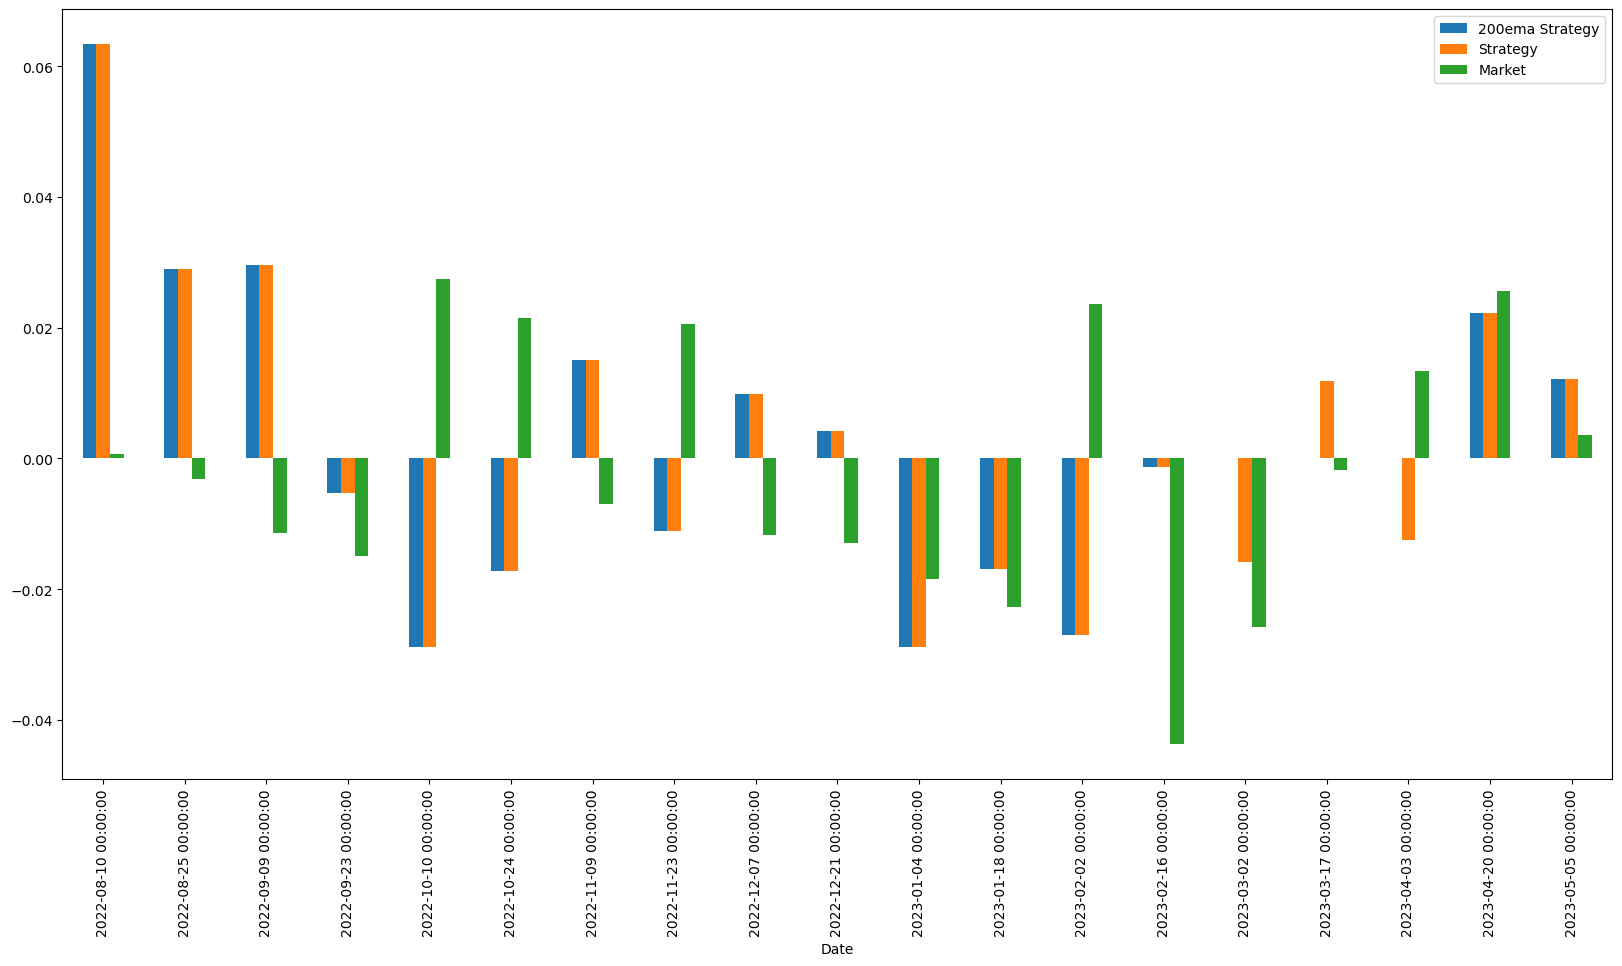

In [260]:
Results[-20:-1].plot.bar()

In [261]:
Finaldf=((Results+1).cumprod())

# Drawdowns

(<Axes: xlabel='Date'>,
 200ema Strategy   -0.268437
 Strategy          -0.522938
 Market            -0.645445
 dtype: float64)

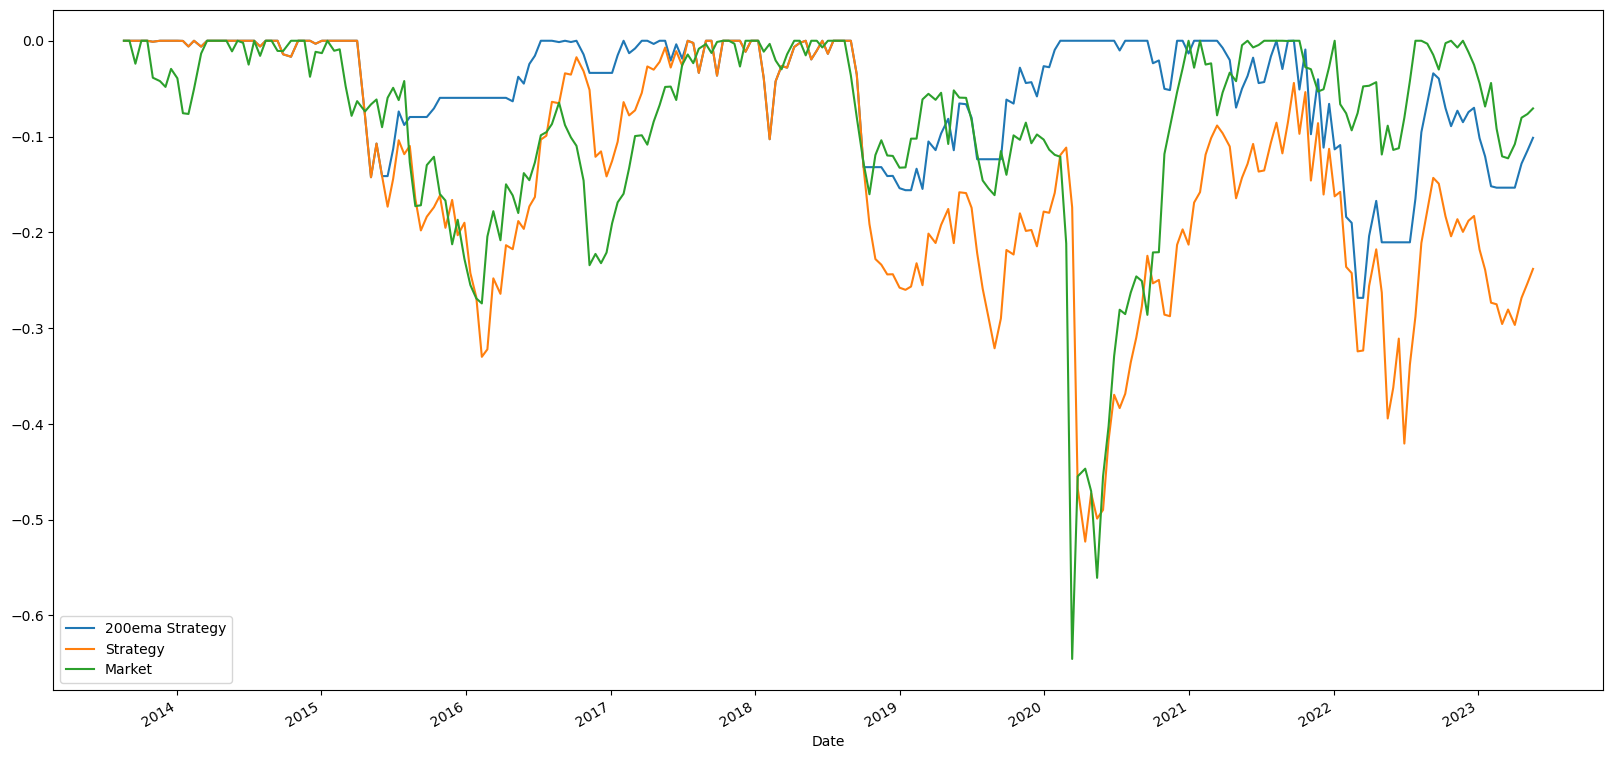

In [263]:
((Finaldf-Finaldf.cummax())/Finaldf).plot(),((Finaldf-Finaldf.cummax())/Finaldf).min()

<Axes: xlabel='Date'>

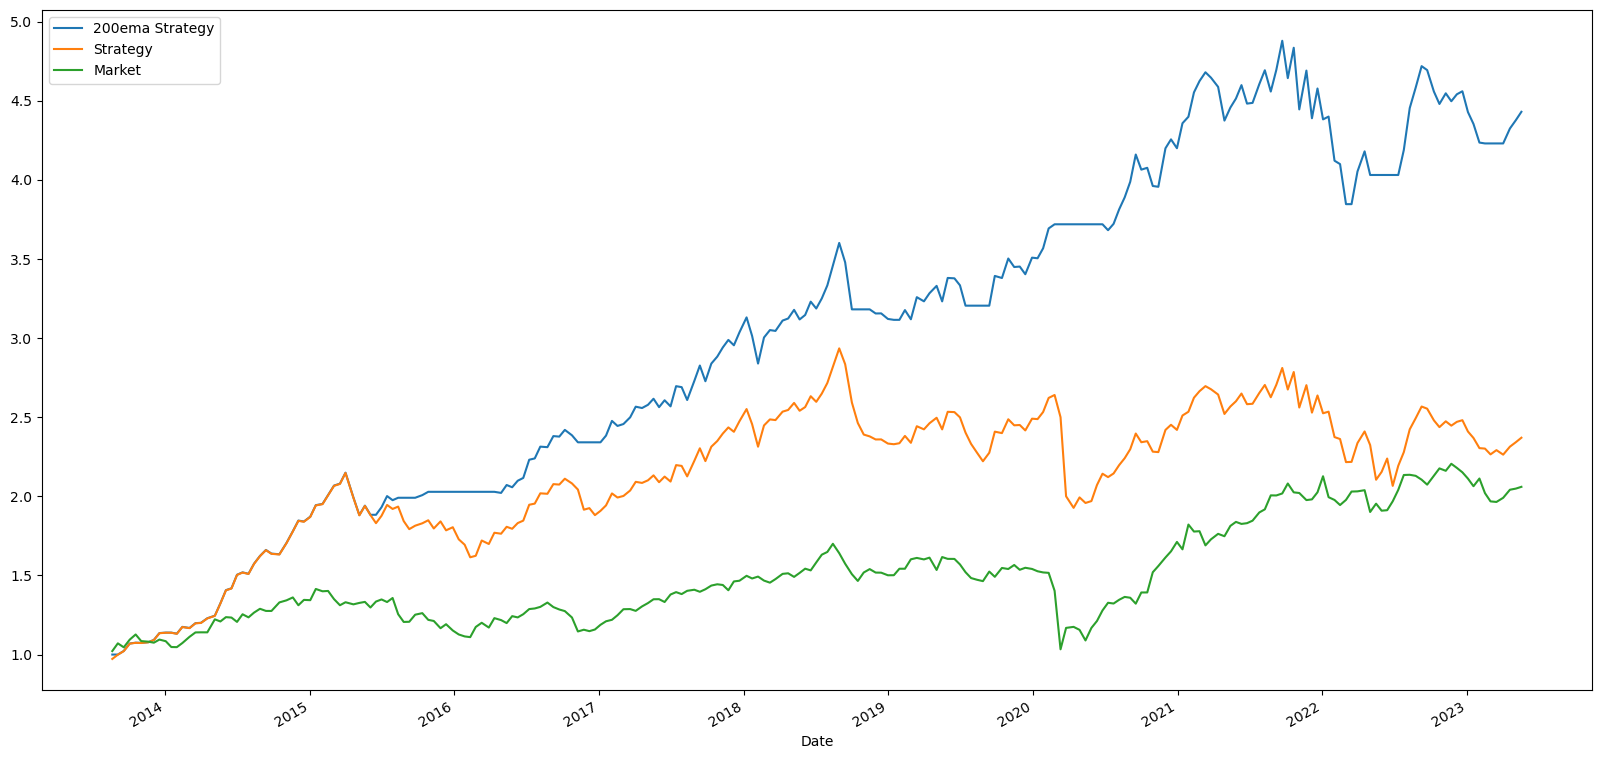

In [264]:
Finaldf.plot()

<Axes: xlabel='Date'>

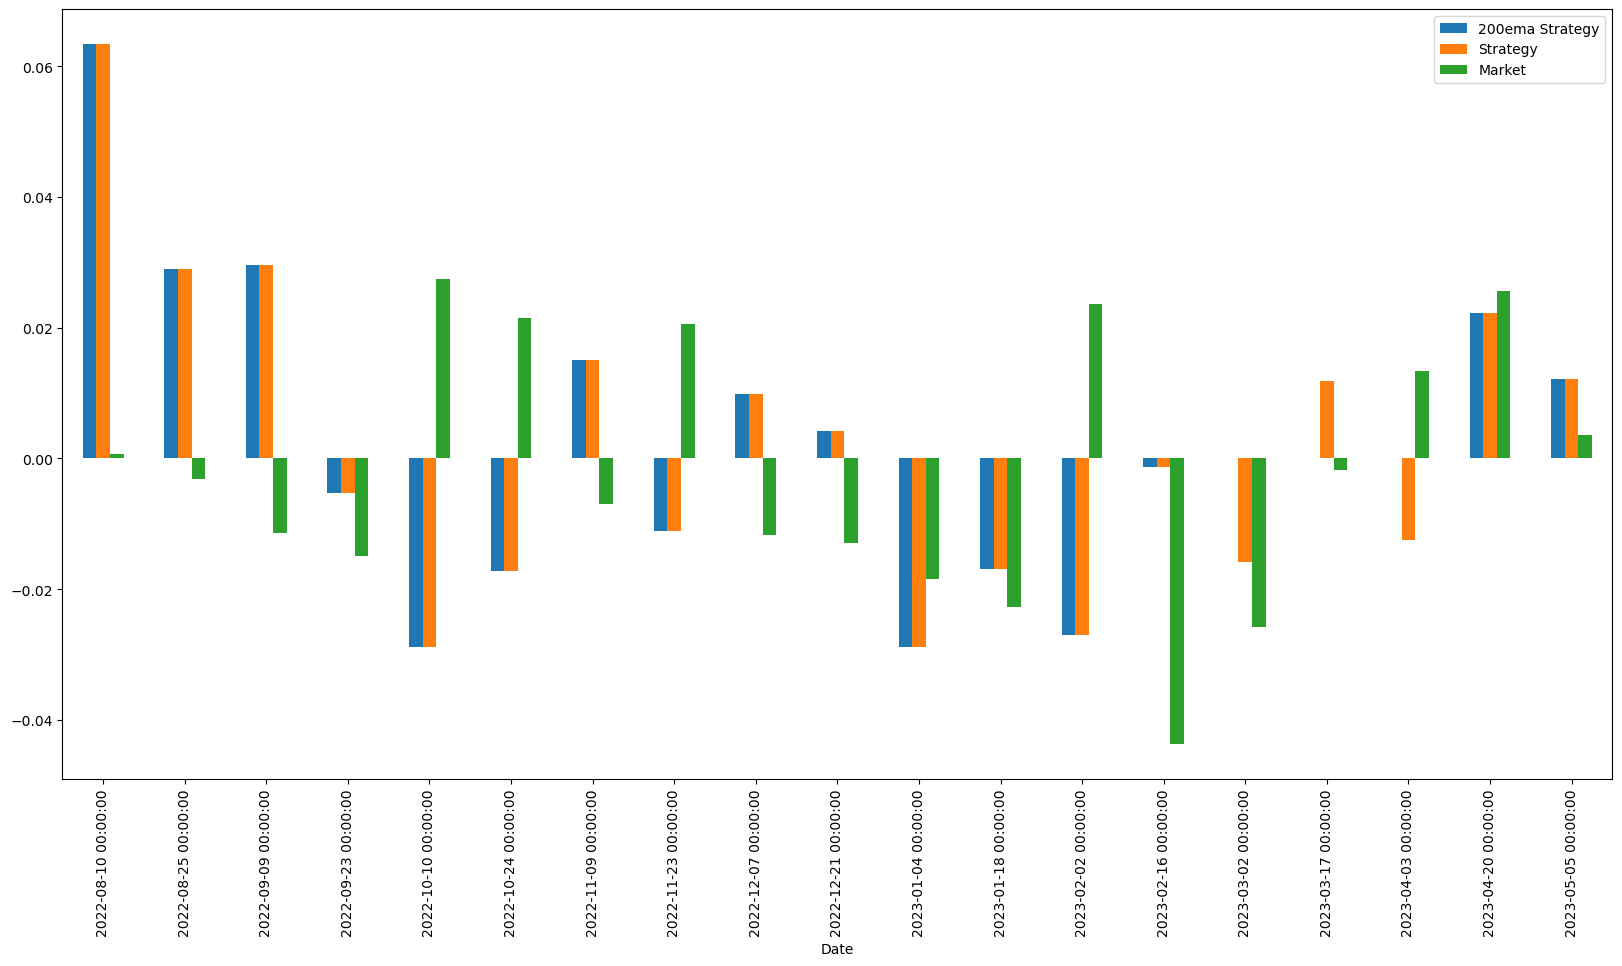

In [265]:
Results[-20:-1].plot.bar()

# Rolling Returns

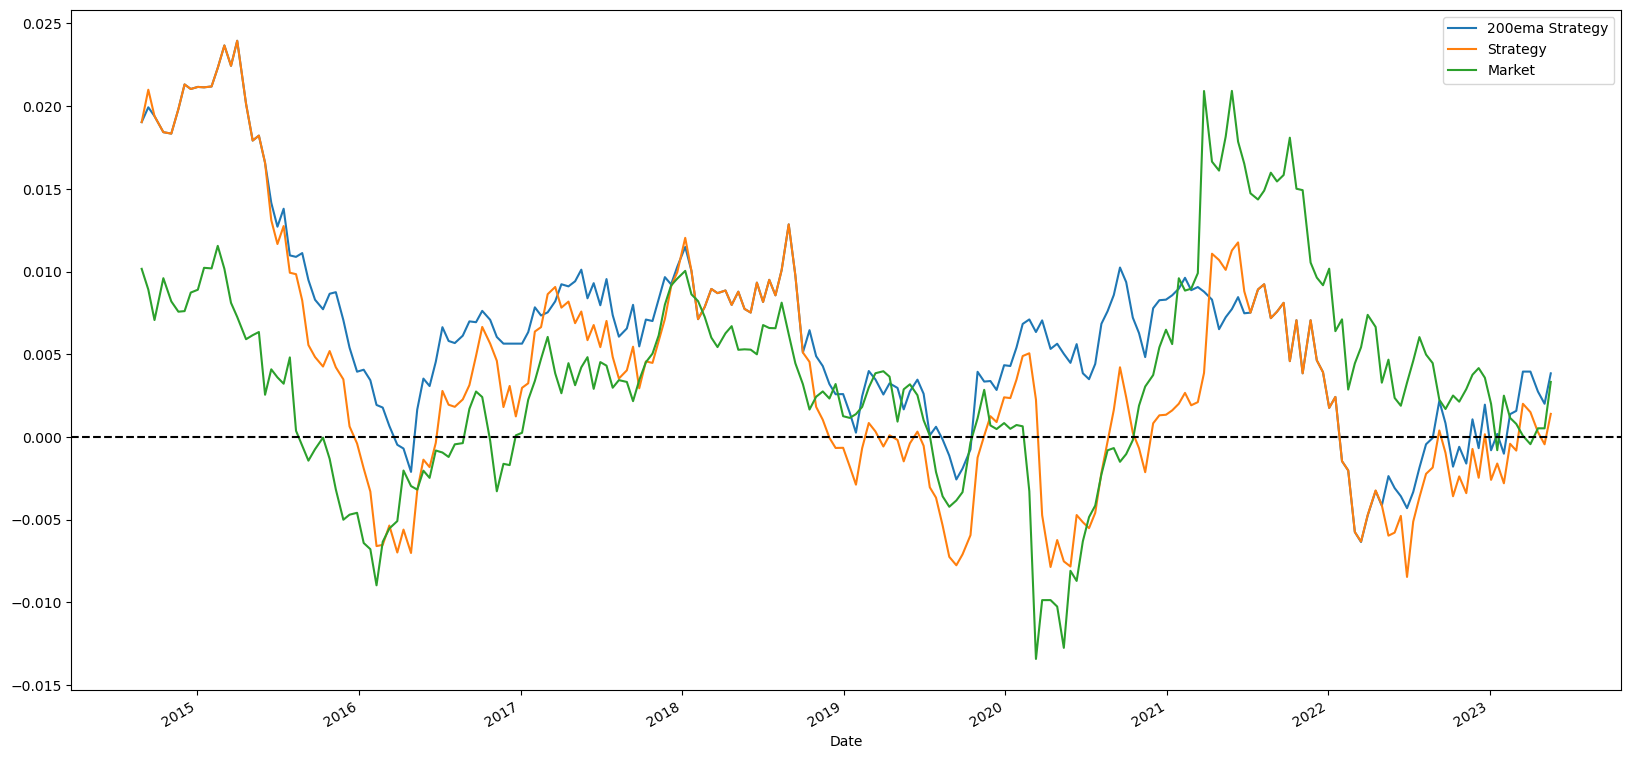

In [266]:
(Results.rolling(window=26).mean()).plot()
plt.axhline(y=0, color='black', linestyle='--')


In [267]:
years=(DataSet[-1][0]-DataSet[0][0]).days/365

# CAGR

In [268]:
((Finaldf.iloc[-1])**(1/(years))-1) *100 

200ema Strategy    16.490679
Strategy            9.254096
Market              7.693120
Name: 2023-05-19 00:00:00, dtype: float64